Class distribution:
label
0    2450
1     490
Name: count, dtype: int64
train gen
Found 2352 validated image filenames belonging to 2 classes.
test gen
Found 1260 images belonging to 1 classes.
val gen
Found 588 validated image filenames belonging to 2 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 224)               229600    
                                                             

C:\Users\madha\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 113s 1s/step - loss: 4.3135 - accuracy: 0.6382 - f1_score: 0.4127 - precision_3: 0.2829 - recall_3: 0.7628 - val_loss: 3.3891 - val_accuracy: 0.8520 - val_f1_score: 0.2162 - val_precision_3: 0.9231 - val_recall_3: 0.1224 - lr: 1.0000e-04
Epoch 2/30
74/74 [==============================] - 104s 1s/step - loss: 3.4862 - accuracy: 0.7440 - f1_score: 0.5446 - precision_3: 0.3871 - recall_3: 0.9184 - val_loss: 2.8277 - val_accuracy: 0.9286 - val_f1_score: 0.7375 - val_precision_3: 0.9516 - val_recall_3: 0.6020 - lr: 1.0000e-04
Epoch 3/30
74/74 [==============================] - 104s 1s/step - loss: 2.9664 - accuracy: 0.7810 - f1_score: 0.5870 - precision_3: 0.4281 - recall_3: 0.9337 - val_loss: 2.4255 - val_accuracy: 0.9490 - val_f1_score: 0.8276 - val_precision_3: 0.9474 - val_recall_3: 0.7347 - lr: 1.0000e-04
Epoch 4/30
74/74 [==============================] - 105s 1s/step - loss: 2.5832 - accuracy: 0.8180 - f1_score: 0.6373 - precision_3: 0.4772 -

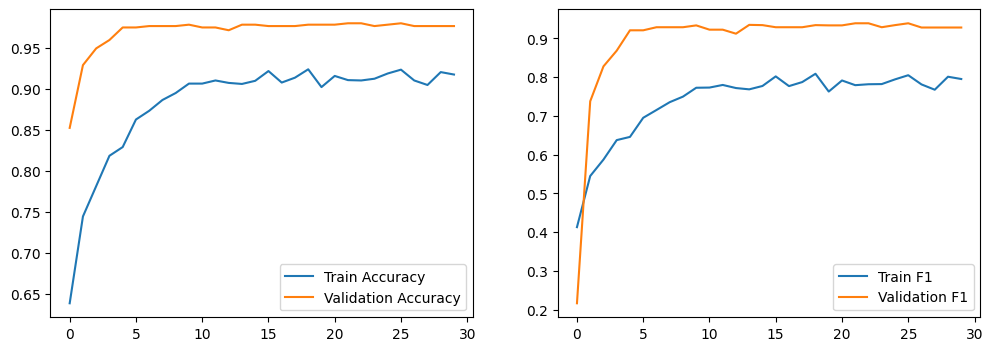

In [2]:
# %% [markdown]
# # Tuberculosis Detection - Corrected Version

# %% [code]
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# %% [markdown]
# ## Data Preparation

# %% [code]
# Configure paths
TRAIN_IMAGES_DIR = r"E:\ML_IITKanpur\TB_Dataset\TB_Dataset\Training_Dataset_TB"
CSV_PATH = r"E:\ML_IITKanpur\TB_Dataset\TB_Dataset\TB_train.csv"
TEST_IMAGES_DIR = r"E:\ML_IITKanpur\TB_Dataset\TB_Dataset\Test_Dataset_TB"

# Load data
train_df = pd.read_csv(CSV_PATH)
train_df = train_df.rename(columns={'ID': 'filename', 'Target': 'label'})
train_df['label'] = train_df['label'].astype(str)

# Show class distribution
print("Class distribution:")
print(train_df['label'].value_counts())

# %% [markdown]
# ## Data Pipeline

# %% [code]
# Custom F1 metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)
        
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='constant'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Split data
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label'],
    random_state=42
)

# Create generators
print("train gen")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_IMAGES_DIR,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb"
)

print("test gen")
test_generator = test_datagen.flow_from_directory(
    directory=TEST_IMAGES_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=False
)
print("val gen")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=TRAIN_IMAGES_DIR,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

# %% [markdown]
# ## Model Architecture (Corrected)

# %% [code]
# Define the base model separately for fine-tuning
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Function to build the model
def build_model(base_model):
    base_model.trainable = False  # Freeze the base model initially
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(224, activation='relu', kernel_regularizer='l2')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs, outputs)

model = build_model(base_model)
model.summary()

# %% [markdown]
# ## Training

# %% [code]
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_f1_score', patience=10, mode='max'),
    ModelCheckpoint('best_model.h5', monitor='val_f1_score', save_best_only=True),
    ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=7)
]

# Compile
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', F1Score(), Precision(), Recall()]
)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,
    class_weight={0: 1, 1: 3}  # Adjust based on your imbalance
)

# %% [markdown]
# ## Evaluation

# %% [code]
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Train F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.legend()
plt.show()

# %% [markdown]
# ## Test Prediction

# %% [code]


In [ ]:
# model.load_weights('best_model.h5') # Load best weights from stage 1

# # Decide which layers to unfreeze (example: unfreeze layers from 'conv5_block1_0_bn' onwards)
# # Find the layer index:
# # for i, layer in enumerate(base_model.layers):
# #     print(i, layer.name) # Find the layer name you want to unfreeze from

# unfreeze_from_layer = 'conv5_block1_0_bn' # Example layer name
# set_trainable = False
# for layer in base_model.layers:
#     if layer.name == unfreeze_from_layer:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

# print(f"Base model layers trainable: {sum(1 for layer in base_model.layers if layer.trainable)}")

# # Re-compile the model with a very low learning rate
# model.compile(
#     optimizer=Adam(learning_rate=1e-5), # Use a much smaller LR for fine-tuning
#     loss='binary_crossentropy',
#     metrics=['accuracy', F1Score(), Precision(), Recall()]
# )

# # Continue training (fine-tuning)
# history_fine_tune = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=20, # Train for more epochs, but EarlyStopping will likely trigger
#     callbacks=callbacks, # Reuse or adjust callbacks (e.g., lower patience for ReduceLROnPlateau)
#     class_weight={0: 1, 1: 3} # Keep class weights
# )

# # Make sure to save the final fine-tuned model
# model.save('fine_tuned_model.h5')

In [ ]:
from sklearn.metrics import f1_score

model.load_weights('fine_tuned_model.h5') # Load best weights from stage 1
# Assuming 'val_generator' is set up correctly and you loaded the best model
val_preds = model.predict(val_generator)
val_labels = val_generator.classes # Get true labels

best_f1 = 0
best_threshold = 0.5

for threshold in np.arange(0.1, 0.9, 0.01):
    f1 = f1_score(val_labels, (val_preds > threshold).astype(int))
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best validation F1: {best_f1:.4f} at threshold: {best_threshold:.2f}")

In [3]:
predictions = model.predict(test_generator)
results = pd.DataFrame({
    'filename': test_generator.filenames,
    'prediction': (predictions > .5).astype(int).flatten()
})
results.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

1260/1260 [==============================] - 117s 92ms/step
Predictions saved to predictions.csv
